# Topological measures of co-firing graphs
## Gava et al, 2021

### Import libraries

In [1]:
import os, warnings
import numpy as np
import pandas as pd
import pickle as pickle
import networkx as nx
from sklearn.decomposition  import PCA
# Plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import dabest
rcParams['ytick.direction'] = 'out'
rcParams['xtick.direction'] = 'out'
%matplotlib inline
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['svg.fonttype'] = 'none'
# Custom libraries
import util_func as uf
import difference_estimation_plot as dpl
# no warning display
warnings.filterwarnings('ignore')

### Set parameters

In [3]:
# directory
homeDir = os.getcwd() # make sure it's the folder level where the script resides
# plotting parameters
RED = sns.hls_palette(20,l=.5,s=1)[0]
PURPLE = sns.hls_palette(10,l=.45,s=1)[8]
BLUE = sns.hls_palette(15,l=.6,s=1)[9]#sns.xkcd_palette(['windows blue'])[0]
GREEN = sns.hls_palette(8,l=.4,s=.8)[3]
ORNG = sns.hls_palette(20,l=.5,s=1)[2] #sns.color_palette('husl',8)[1]
GRAY = [0.6,0.6,0.6]
colorsG = [GRAY,RED,ORNG,BLUE,PURPLE,GREEN]
RED_G = sns.color_palette('husl')[0] # used for graph visualisation
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)
# sessions labels
sess_label = {'cpp':['Exposure','Pre-test','+Suc.','+Wat.','CPP test','Re-exposure'],
              'spp':['Exposure','Pre-test','Nov 1','Nov 2','CPP test','Re-exposure'],
              'novel-only':['Exposure','Nov 1a','Nov 1b','Nov 1c','Nov 1d','Re-exposure'],
              'familiar-reward':['Exposure','Fam 2a','Nov 1','Nov 2','Fam 2d','Re-exposure']}

In [4]:
### Load names of precomputed principal cells co-firing graphs (i.e. co-firing matrices)
# obtain list of recording days
for _,_,file in os.walk(homeDir+'/data/'):
    dataList = file
# initialise batch variables
exp_names = []
w = {}; clu = {}; plw = {}; netD = {}

# BATCH WORK
for dd,dataname in enumerate(dataList): # loop over recording days / experiments
    # load data for single exp
    exp_name = dataname.split('.')[0].split('_')[-1] # obtain the experiment label
    exp_names.append(exp_name)
    bsnm = dataname.split('_')[0]
    print('- processing', exp_name, 'example...')
    # load data
    with open(homeDir+'/data/'+dataname,'rb') as f:
        data = pickle.load(f)
    allKEYS = list(data.keys())
    allKEYS_ = allKEYS.copy() # make a deep copy for extra looping within the loop
    print(allKEYS)
    w[exp_name] = {}; clu[exp_name] = {}; plw[exp_name] = {}; netD[exp_name] = {}
    # loop over sessions
    for k,k2 in zip(sess_label[exp_name],allKEYS): # loop over sessions
        g = data[k2]
        w[exp_name][k] = g
        # networkx measures
        graph = nx.Graph(g)
        clu[exp_name][k] = list(uf.clustering(graph,weight='weight').values())
        plw[exp_name][k] = uf.wNetGeoPathLength(g.copy())
        # matrix topological distance analysis
        netRef = g + np.identity(g.shape[0]) # fill diaginal to ensure matrix positivness
        keys2 = zip(sess_label[exp_name],allKEYS_) # indeces to loop over sessions again
        for kk,kk2 in keys2: # loop again over sessions to obtain topological distances
            if kk==sess_label[exp_name][0]: # initialise dict if first iter
                netD[exp_name][k] = {} 
            g = data[kk2] # other network from which to measure the distance
            if kk==k: # self distance case (add noise to avoid distance of 0)
                perturb = uf.symm_matPerturb(g,scale=1); np.fill_diagonal(perturb,0)
                gPosDef = g + np.identity(g.shape[0])
                comp = gPosDef + perturb
                netD[exp_name][k][kk] = uf.dist_riem_LE(netRef,comp)
            else: # different session from the reference one
                gPosDef = g + np.identity(g.shape[0])
                netD[exp_name][k][kk] = uf.dist_riem_LE(netRef,gPosDef)
print('\nThe available experiments are',exp_names)

- processing spp example...
['f 1_1', 'n1n2 pretest_2', 'n 1_3', 'n 2_4', 'n1n2 test_5', 'f 1_6']
- processing cpp example...
['f 1_1', 'n1n2 pretest_2', 'n2 suc_3', 'n1 wat_4', 'n1n2 test_5', 'f 1_6']
- processing familiar-reward example...
['f 1_1', 'f 2a_2', 'f 2suc_3', 'f 2wat_4', 'f 2d_5', 'f 1_6']
- processing novel-only example...
['f 1_1', 'n 1a_2', 'n 1b_3', 'n 1c_4', 'n 1d_5', 'f 1_6']

The available experiments are ['spp', 'cpp', 'familiar-reward', 'novel-only']


### Load the co-firing graphs and compute the topological measures

One co-firing graph was obtained per session (e.g. enclosure, pre-test, re-exposure, ...), each of them is represented by its $NxN$ adjacency matrix (N is the number of principal cells recorded over the recording day).

Each of the matrix elements $(i,j)$ was obtained as the Pearson correlation coefficient between the spiketrains of the neuron $i$ and $j$, each smoothed through convolution with a $40ms$ Gaussian.

### Visualise one example co-firing graph and its adjacency matrix

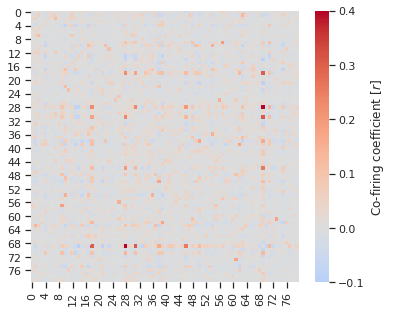

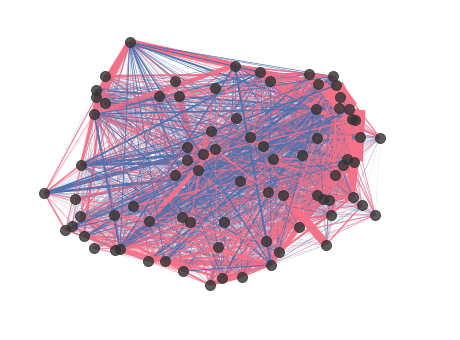

In [22]:
# select co-firing graph to visualise
EXP = 'cpp' # recording day index -- CPP
SID = 0 # exposure session
K = sess_label[EXP][SID] # session index -- exposure
# obtain the graph
adjmat = w[EXP][K]
graph = nx.Graph(adjmat)
# plot adj matrix
sns.set(style='ticks', font_scale=1)
plt.figure(figsize=(6,5))
sns.heatmap(adjmat, cbar=True, vmax=.4, vmin=-.1, center=0,
            cmap='coolwarm', cbar_kws={'label':'Co-firing coefficient [$r$]'})
# visualise graph with networkX
plt.figure(figsize=(8,6))
uf.plotWeightedGraph(adjmat, graphType='spring', scale=0.4, Labels=0,
                     nodeC=[.2,.2,.2], nodeSize=100, posC=RED_G)

Session Exposure: co-firing S 0.07 | geo path length 84.2 | clust coeff -0.001
Session Pre-test: co-firing S 0.06 | geo path length 73.2 | clust coeff 0.006
Session +Suc.: co-firing S 0.09 | geo path length 59.4 | clust coeff 0.006
Session +Wat.: co-firing S 0.10 | geo path length 79.2 | clust coeff 0.030
Session CPP test: co-firing S 0.13 | geo path length 52.5 | clust coeff 0.121
Session Re-exposure: co-firing S 0.10 | geo path length 67.6 | clust coeff 0.056


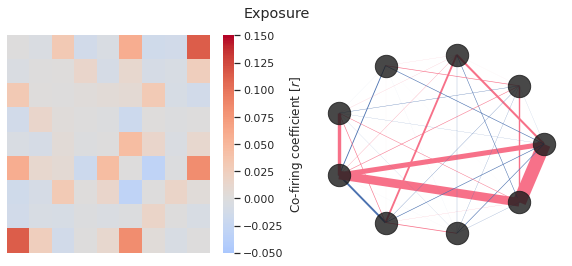

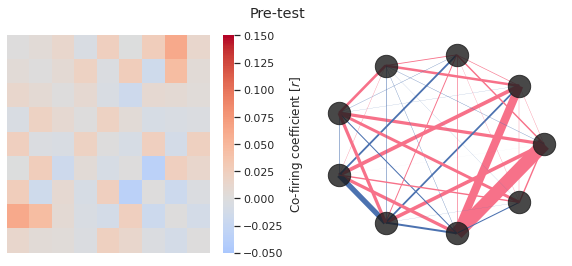

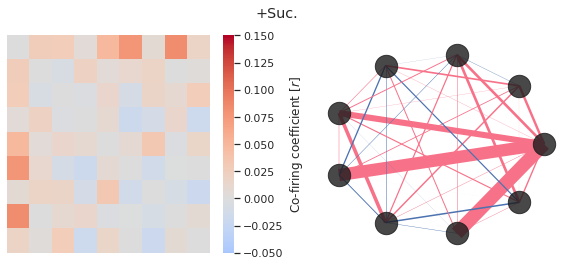

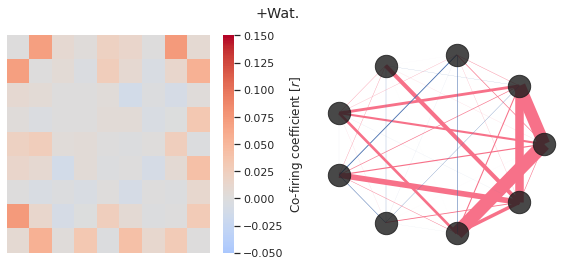

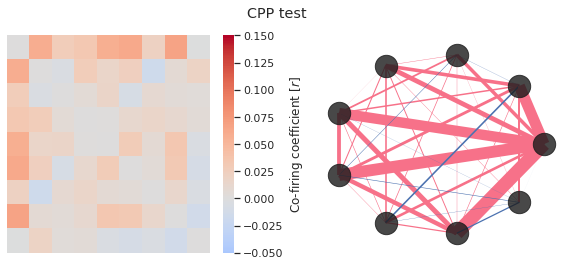

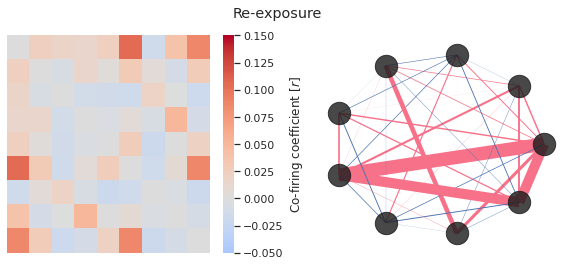

In [24]:
### Plot subgraphs across sessions
nc = 7 # number of cells to display
for k in sess_label[D]:
    adjmat = w[D][k] #  graph copy to obtain indiv units to visualise
    if K==sess_label[D][0]: # obtain indice of most correlated units to form subgraph to display
        indd = np.argsort(np.std(np.abs(adjmat),0))[::-1] # select the nodes with the largest std
        IND = [10,52,14,65,59,50,23,25,49] # picked from visual inspection
        IX = np.ix_(IND,IND) # matrix indeces
    # obtain subgraph measures
    GGG = adjmat[IX] # extract  subgraph
    G = nx.Graph(GGG)
    avgS = np.mean(GGG.sum(0)) # average neurons co-firing strength
    avgClu = np.mean(list(uf.clustering(G,weight='weight').values())) # average clustering
    avgPL = np.nanmean(uf.wNetGeoPathLength(GGG.copy())) # average PL
    # PLOTTING
    plt.figure(figsize=(10,4))
    plt.suptitle(k)
    plt.subplot(121)
    sns.heatmap(GGG, cmap='coolwarm', center=0, vmin=-.05 ,vmax=.15,
                cbar_kws={'label':'Co-firing coefficient [$r$]'})
    plt.axis('off');
    plt.subplot(122)
    uf.plotWeightedGraph(GGG, graphType='circ', scale=1.5, nodeC='k', posC=RED_G)
    print('Session %s: co-firing S %.2f | geo path length %.1f | clust coeff %.3f'\
          %(k,avgS,avgPL,avgClu))

### Visualise the examples topology over sessions

Text(0, 0.5, 'Median $\\Delta$')

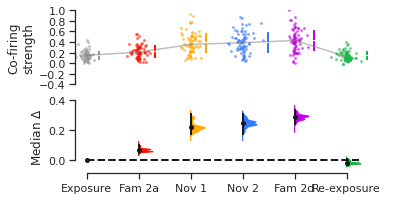

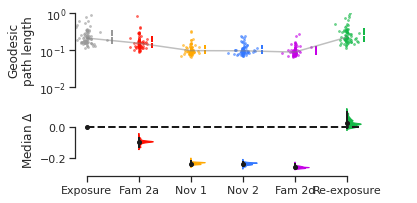

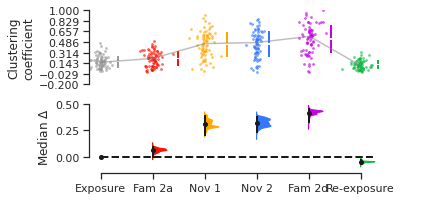

In [26]:
### Select which dataset example to visualise
EXP = 'familiar-reward' # choose which dataset to visualise
KEYS = sess_label[EXP]

# functions to index topological measures
OUT = lambda f,k: f[k][n][:,:]
IO = lambda f,k: np.asarray(f[n])[:]

# set plotting parameters
sns.set(style='ticks', font_scale=1.2)

# NETWORK STRENGTH
m_norm = {}
m_out = {}
for k in KEYS:
    m_out[k] = []
    m_norm[k] = np.nansum(w[EXP][k],1)
# normalise it
norm = np.max([np.max(m_norm[k]) for k in KEYS])
for k in KEYS:
    m_out[k] = m_norm[k]/norm
# display
df = pd.DataFrame()
for nk,k in enumerate(KEYS): df[sess_label[EXP][nk]] = m_out[k]
ax, m, p = dpl.estimation_plot(df, ci=.99, operation=np.median, figsize=(6,3),
                           swarmPlot_kw={'label':'Co-firing\nstrength'},
                           color_palette=colorsG)
ymin = -0.4; ymax = 1
ax[0].set_xticks([])
ax[0].set_yticks(np.linspace(ymin,ymax,8))
ax[0].set_ylim(ymin,ymax)
ax[1].set_ylabel('Median $\Delta$')

# GEO PATH LENGTH
m_norm = {}
m_out = {}
for k in KEYS:
    m_out[k] = []
    m_norm[k] = np.nanmean(plw[EXP][k],1)
# normalise it
norm = np.max([np.nanmax(m_norm[k]) for k in KEYS])
for k in KEYS:
    m_out[k] = m_norm[k]/norm
x = [m_out[k] for k in KEYS]
# display
df = pd.DataFrame()
for nk,k in enumerate(KEYS): df[sess_label[EXP][nk]] = x[nk]
ax, m, p = dpl.estimation_plot(df, ci=.99, operation=np.median, figsize=(6,3),
                           swarmPlot_kw={'label':'Geodesic\npath length'},
                           color_palette=colorsG)
# ymin = -2; ymax = 0
ax[0].set_xticks([])
ax[0].set_yticks(np.linspace(ymin,ymax,3))
ax[0].set_yticklabels(['$10^{-2}$','$10^{-1}$','$10^0$'])
ax[0].set_ylim(ymin,ymax)
ax[1].set_ylabel('Median $\Delta$')

# CLUSTERING
m_norm = {}
m_out = {}
for k in KEYS:
    m_out[k] = []
    m_norm[k] = clu[EXP][k]
# normalise it
norm = np.max([np.nanmax(m_norm[k]) for k in KEYS])
for k in KEYS:
    m_out[k] = m_norm[k]/norm
# display
df = pd.DataFrame()
for nk,k in enumerate(KEYS): df[sess_label[EXP][nk]] = m_out[k]
# plotting
ax, m, p = dpl.estimation_plot(df, ci=.99, operation=np.median, figsize=(6,3),
                           swarmPlot_kw={'label':'Clustering\ncoefficient'},
                           color_palette=colorsG)
ymin = -0.2; ymax = 1
ax[0].set_xticks([])
ax[0].set_yticks(np.linspace(ymin,ymax,8))
ax[0].set_ylim(ymin,ymax)
ax[1].set_ylabel('Median $\Delta$')

### Topological distance analysis

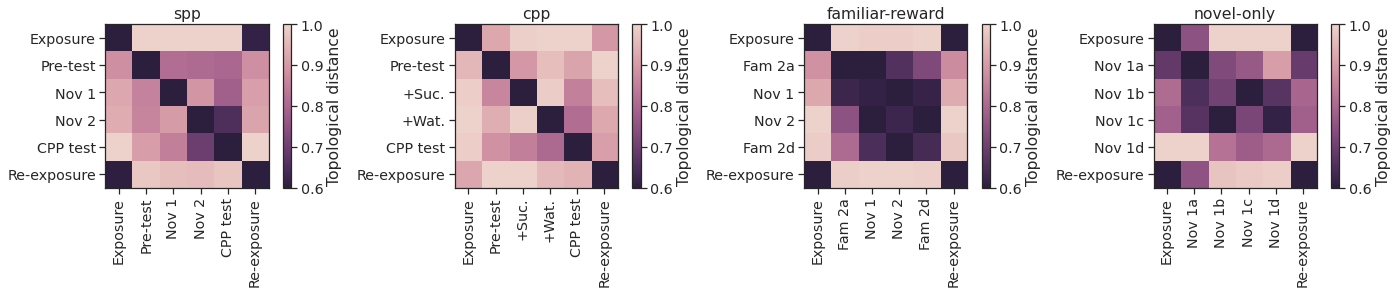

In [13]:
plt.figure(figsize=(24,3))
for ne,EXP in enumerate(exp_names): # loop over datasets
    KEYS = sess_label[EXP]
    topoDmat = np.zeros((len(KEYS),len(KEYS)))
    for nk,k in enumerate(KEYS):
        temp = np.asarray([np.absolute(netD[EXP][k][kk]) for kk in KEYS]) # obtain row of the matrix
        topoDmat[:,nk] = temp/np.max(temp) # normalise
    plt.subplot(1,4,ne+1)
    plt.title(EXP)
    plt.imshow(topoDmat,cmap=sns.cubehelix_palette(20,reverse=True,as_cmap=True))
    cbar = plt.colorbar(); plt.clim(0.6,1); cbar.set_label('Topological distance')
    plt.xticks(range(6),sess_label[EXP],rotation=90); plt.yticks(range(6),sess_label[EXP])